In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import OrderedDict as odict
import numpy as np
from tqdm.notebook import tqdm

import math
import torch
import torch.nn as nn

from utils import ssv
from generator import Generator
from torchsummaryX import summary
from clevr_dataset import CLEVRDataset, collate_fn
from ssv import VPNet, VPAwareSynthesizer
import torchvision
import torchvision.transforms as T

import matplotlib.pyplot as plt

In [3]:
import torchvision as tv

def to_pil_grid(batch, nrow=8):
    return tv.transforms.functional.to_pil_image(tv.utils.make_grid(batch, nrow=nrow))

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [5]:
%%time
dataset = CLEVRDataset('/storage1/datasets/CLEVR_v1.0/', 'train', image_sizes=((128, 128),))

CPU times: user 10.1 s, sys: 813 ms, total: 10.9 s
Wall time: 10.9 s


In [6]:
##
class ComponentDecoder(nn.Module):
    def __init__(
        self, in_nc=64, kss=[3, 3, 3], ncs=[64, 32, 32], ss=[1, 1, 1], act="elu"
    ):
        super().__init__()
        # if act == "elu":
        #     act = nn.ELU

        in_nc = in_nc + 2
        conv_layers = []
        for ks, nc, s in zip(kss, ncs, ss):
            conv_layers.append(
                nn.Sequential(
                    nn.Conv2d(
                        kernel_size=ks,
                        in_channels=in_nc,
                        out_channels=nc,
                        stride=s,
                        padding=1,
                    ),
                    nn.BatchNorm2d(nc),
                    nn.LeakyReLU(0.2),
                )
            )
            in_nc = nc
        self.conv_layers = nn.Sequential(*conv_layers)

        self.out_proj = nn.Conv2d(
            kernel_size=3, in_channels=in_nc, out_channels=3, stride=1, padding=1
        )
        self.apply(self.weights_init)
        
        
    @staticmethod
    def weights_init(m):
        if isinstance(m, nn.Conv2d):
            torch.nn.init.normal_(m.weight, 0, 0.02)
            torch.nn.init.zeros_(m.bias)

    def forward(self, inp, shape=(128, 128)):
        x = torch.linspace(-1, 1, shape[0])
        y = torch.linspace(-1, 1, shape[1])
        x, y = torch.meshgrid(x, y)

        x = x.view(1, 1, *x.size()).expand(inp.size(0), -1, -1, -1).to(inp.device)
        y = y.view(1, 1, *y.size()).expand(inp.size(0), -1, -1, -1).to(inp.device)

        _inp = inp.view(*inp.size(), 1, 1).expand(-1, -1, shape[0], shape[1])
        broadcasted_bg = torch.cat((_inp, x, y,), 1)
        return self.out_proj(self.conv_layers(broadcasted_bg))
    
from torch.nn.functional import affine_grid, grid_sample

def stn(img, center, scale, out_shape, inverse=False):
    bsz, C, H, W = img.size()
    theta_h, theta_w = scale.view(-1, 2).split(1, -1)
    theta_tx, theta_ty = center.view(-1, 2).split(1, -1)
    num_glimpses = theta_h.size(0) // bsz
    
    # transformation, zero values are crop skewness, for now without skew
    theta = torch.cat(
        [
            theta_w,
            torch.zeros_like(theta_w),
            theta_ty,
            torch.zeros_like(theta_w),
            theta_h,
            theta_tx,
        ],
        dim=-1,
    )
    theta = theta.view(-1, 2, 3)

    if inverse:
        t = torch.tensor([0.0, 0.0, 1.0], device=theta.device).repeat(
            theta.size(0), 1, 1
        )
        t = torch.cat([theta, t], dim=-2)
        t = t.inverse()
        theta = t[:, :2, :]

    grid = affine_grid(theta, (theta.size(0), C, *out_shape), align_corners=False)
    # repeat each image Hp * Wp times for each cropping
    _img = img.unsqueeze(1).expand(-1, num_glimpses, -1, -1, -1)
    _img = _img.reshape(-1, C, H, W)
    xs = grid_sample(_img, grid, align_corners=False)
    return xs.view(bsz, num_glimpses, C, *out_shape)

def calculate_center_scale_wrt_img(img, shift_01, scale_01, anchor_shape=(64, 64)):
    # img: (bsz, 3, 128, 128)
    # scale: (bsz, 16, 16, 2)
    # shift: (bsz, 16, 16, 2)
    bsz, C, H, W = img.size()
    anchor_shape = torch.as_tensor(anchor_shape, device=img.device)
    image_shape = torch.tensor((H, W), dtype=torch.float, device=scale_01.device)
    Hp, Wp = scale_01.size()[1:3]
    fmap_shape = torch.tensor((Hp, Wp), dtype=torch.float, device=scale_01.device)

    scale_wrt_anchor = scale_01
    shift_wrt_fmap = shift_01

    scale_abs = scale_wrt_anchor * anchor_shape
    scale_wrt_img = scale_abs / image_shape
    shift_wrt_img = shift_wrt_fmap / fmap_shape

    # z_scale_abs: size in pixels, according to SPAIR, using a
    # constant anchor instead of a possible
    # variable image size is better
    scale_abs = scale_wrt_anchor * anchor_shape
    scale_wrt_img = (
        scale_abs / image_shape
    )  # size in range (0, GLIMPSE_SIZE / IMAGE_SIZE)

    # ij_grid: coordinate map with values (x, y) in ((0, 1), (0, 1)) where
    # 0 is the left/top-most position of the image and 1 the right/bottom-most
    # each coordinate denotes the top-left corner of the projected
    # pseudo-receptive field in the original image for each cell of the
    # feature map
    ij_grid = torch.stack(
        torch.meshgrid((torch.linspace(0, 1 - 1 / Hp, Hp), torch.linspace(0, 1 - 1 / Wp, Wp))),
        dim=-1,
    ).to(img.device)
    center_wrt_img = ij_grid.unsqueeze(0) + shift_wrt_img
    # z_center_wrt_img__11: transformed values of centers relative
    # to the image to range (-1, 1) to use with torch.nn.functional.make_grid
    center_wrt_img__11 = (center_wrt_img * 2) - 1

    return center_wrt_img__11, scale_wrt_img

from collections import OrderedDict as odict

class GlimpseEncoder(nn.Module):
    def __init__(
        self,
        ncs=[16, 32, 64, 64, 128, 128, 128],
        kss=[3, 4, 3, 4, 3, 4, 4],
        ss=[1, 2, 1, 2, 1, 2, 1],
        gs=[4, 8, 8, 8, 4, 8, 16, 8],
        pds=[1, 1, 1, 1, 1, 1, 0],
        out_proj_dim=128,
        act="relu",
    ):
        super().__init__()

        conv_layers = []
        prev_nc = 3
        for nc, ks, s, pd, ng in zip(ncs, kss, ss, pds, gs):
            conv_layers.append(
                nn.Sequential(
                    nn.Conv2d(
                        in_channels=prev_nc,
                        out_channels=nc,
                        kernel_size=ks,
                        stride=s,
                        padding=pd,
                    ),
                    nn.GroupNorm(num_groups=ng, num_channels=nc),
                    nn.LeakyReLU(0.2),
                )
            )
            prev_nc = nc
        self.conv_layers = nn.Sequential(*conv_layers)
        self.out_proj = nn.Conv2d(
            in_channels=prev_nc, out_channels=out_proj_dim, kernel_size=1,
        )
        # self.out_pool = nn.AvgPool2d(3, 3)

    def forward(self, x):
        return self.out_proj(self.conv_layers(x))

class GlimpseDecoder(nn.Module):
    def __init__(
        self,
        in_nc=128,
        out_proj_nc=16,
        conv_ncs=[128, 128, 64, 64, 32],
        conv_ss=[1, 1, 1, 1, 1, 1],
        conv_gns=[16, 16, 16, 8, 8],
        conv_kss=[1, 3, 3, 3, 3],
        conv_pds=[0, 1, 1, 1, 1],
        sub_conv_factors=[2, 2, 2, 2, 2],
        sub_conv_ncs=[128, 64, 64, 32, 16],
        sub_conv_ss=[1, 1, 1, 1, 1],
        sub_conv_gns=[16, 16, 8, 8, 4],
        out_proj_dim=16,
        out_proj_ks=3,
        out_proj_stride=1,
        act="celu",
    ):
        super().__init__()

        act = nn.LeakyReLU(0.2)
        conv_layers = odict([])
        prev_num_channels = in_nc
        for i, (nc, ks, s, gn, pd, sc_f, sc_nc, sc_s, sc_gn) in enumerate(
            zip(
                conv_ncs,
                conv_kss,
                conv_ss,
                conv_gns,
                conv_pds,
                sub_conv_factors,
                sub_conv_ncs,
                sub_conv_ss,
                sub_conv_gns,
            )
        ):
            conv_layers[f"group_conv{i}"] = nn.Sequential(
                odict(
                    [
                        (
                            f"conv{i}",
                            nn.Sequential(
                                nn.Conv2d(
                                    in_channels=prev_num_channels,
                                    out_channels=nc,
                                    kernel_size=ks,
                                    stride=s,
                                    padding=pd,
                                ),
                                nn.GroupNorm(num_groups=gn, num_channels=nc),
                                nn.LeakyReLU(0.2),
                            ),
                        ),
                        (
                            f"sub_conv{i}",
                            nn.Sequential(
                                nn.Conv2d(
                                    in_channels=nc,
                                    out_channels=sc_nc * sc_f ** 2,
                                    stride=sc_s,
                                    kernel_size=1,
                                ),
                                nn.PixelShuffle(sc_f),
                                nn.GroupNorm(num_groups=sc_gn, num_channels=sc_nc),
                                nn.LeakyReLU(0.2),
                            ),
                        ),
                    ]
                )
            )
            prev_num_channels = sc_nc
        self.conv_layers = nn.Sequential(conv_layers)
        self.out_proj = nn.Sequential(
            nn.Conv2d(
                in_channels=prev_num_channels,
                out_channels=out_proj_nc,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            # nn.GroupNorm(num_groups=out_proj_nc // 4, num_channels=out_proj_nc),
            nn.InstanceNorm2d(num_features=out_proj_nc),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=out_proj_nc, out_channels=4, kernel_size=1,),
        )
        self.apply(self.weights_init)
        self.out_proj[-1].weight.data.normal_()
        
    @staticmethod
    def weights_init(m):
        if isinstance(m, nn.Conv2d):
            torch.nn.init.normal_(m.weight, 0, 0.02)
            torch.nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.out_proj(self.conv_layers(x))

In [7]:
torch.set_printoptions(linewidth=300, precision=2)

In [15]:
bsz = 4
loader = torch.utils.data.DataLoader(dataset, batch_size=bsz, collate_fn=collate_fn, shuffle=False)
(inp,), targets, lengths = batch = next(iter(loader))
inp = inp.to(device)

In [8]:
def rsample_gaussean(mean, loc):
    dist = torch.distributions.normal.Normal(mean, loc)
    return dist.rsample()

def render_scene(inp, scene, glimpse_encoder, glimpse_decoder, component_decoder, glimpse_shape=(32, 32), beta=1.0):
    bsz, channels, height, width = inp.size()
    scale = scene['fg']['scale']
    shift = scene['fg']['shift']
    depth = scene['fg']['depth']
    presence_logits = scene['fg']['presence_logits']
    sampled_presence_logits = rsample_gaussean(presence_logits, 2)
    sampled_presence = torch.sigmoid(presence_logits * beta)
    height_fmap, width_fmap = sampled_presence.size()[1:3]
    num_glimpses = height_fmap * width_fmap
    z_bg = scene['bg']['z_bg']
    
    center_wrt_img__11, scale_wrt_img = calculate_center_scale_wrt_img(inp, shift, scale)
    glimpses = stn(inp, center_wrt_img__11, scale_wrt_img, glimpse_shape)
    encoded_glimpses = glimpse_encoder(glimpses.flatten(0, 1))
    decoded_glimpses = glimpse_decoder(encoded_glimpses)
    batch_decoded_glimpses = decoded_glimpses.view(bsz, height_fmap, width_fmap, channels + 1, *glimpse_shape)
    alpha_hat_glimpse = torch.sigmoid(beta * batch_decoded_glimpses[:, :, :, [0]]) * sampled_presence.unsqueeze(-1).unsqueeze(-1)
    y_glimpse = torch.sigmoid(batch_decoded_glimpses[:, :, :, 1:]) * alpha_hat_glimpse

    alpha_hat_img = stn(alpha_hat_glimpse.flatten(0, 2), center_wrt_img__11, scale_wrt_img, (height, width), inverse=True)
    alpha_hat_img = alpha_hat_img.view(bsz, num_glimpses, 1, height, width)
    
    y_img = stn(y_glimpse.flatten(0, 2), center_wrt_img__11, scale_wrt_img, (height, width), inverse=True)
    y_img = y_img.view(bsz, num_glimpses, channels, height, width)
    
    w = (100 * depth.view(bsz, num_glimpses, 1, 1, 1) * alpha_hat_img).softmax(1)
    alpha = (w * alpha_hat_img).sum(1)
    mu_fg = (y_img * w).sum(1)
    
    decoded_bg = torch.sigmoid(component_decoder(z_bg))
    
    return alpha, mu_fg, decoded_bg, sampled_presence, center_wrt_img__11.detach(), scale_wrt_img.detach(), alpha_hat_glimpse.detach(), glimpses.detach(), y_glimpse.detach()

In [9]:
def efficient_render_scene(inp, scene, glimpse_encoder, glimpse_decoder, component_decoder, glimpse_shape=(32, 32), beta=1.0):
    bsz, channels, height, width = inp.size()
    z_bg = scene['bg']['z_bg']
    scale = scene['fg']['scale']
    shift = scene['fg']['shift']
    depth = scene['fg']['depth']
    presence_logits = scene['fg']['presence_logits']
    sampled_presence_logits = rsample_gaussean(presence_logits, 2)
    sampled_presence = torch.sigmoid(presence_logits * beta)

    presence_indices = (sampled_presence >= 0.001)
    k = max(presence_indices.flatten(1).sum(1))
    topk_p_values, topk_indices = sampled_presence.flatten(1, 2).topk(k=k, dim=1)
    topk_indices = topk_indices.squeeze(-1)
    batch_indices = torch.arange(bsz).unsqueeze(-1).repeat_interleave(k.item(), 1)

    center_wrt_img__11, scale_wrt_img = calculate_center_scale_wrt_img(inp, shift, scale)
    topk_center_wrt_img__11 = center_wrt_img__11.flatten(1, 2)[batch_indices, topk_indices, :]
    topk_scale_wrt_img = scale_wrt_img.flatten(1, 2)[batch_indices, topk_indices, :]

    glimpses = stn(inp, topk_center_wrt_img__11, topk_scale_wrt_img, glimpse_shape)
    encoded_glimpses = glimpse_encoder(glimpses.flatten(0, 1))
    decoded_glimpses = glimpse_decoder(encoded_glimpses)
    batch_decoded_glimpses = decoded_glimpses.view(bsz, k, channels + 1, *glimpse_shape)
    alpha_hat_glimpse = torch.sigmoid(beta * batch_decoded_glimpses[:, :, [0]]) * topk_p_values.unsqueeze(-1).unsqueeze(-1)
    y_glimpse = torch.sigmoid(batch_decoded_glimpses[:, :, 1:]) * alpha_hat_glimpse

    cat_decoded_glimpse = torch.cat((alpha_hat_glimpse, y_glimpse), 2).flatten(0, 1)
    cat_decoded_img = stn(cat_decoded_glimpse, topk_center_wrt_img__11, topk_scale_wrt_img, (height, width), inverse=True)
    cat_decoded_img = cat_decoded_img.view(bsz, k, 4, height, width)

    alpha_hat_img = cat_decoded_img[:, :, [0]]
    y_img = cat_decoded_img[:, :, 1:]

    topk_depth = depth.flatten(1, 2)[batch_indices, topk_indices, :]
    w = (100 * topk_depth.view(bsz, k, 1, 1, 1) * alpha_hat_img).softmax(1)
    alpha = (w * alpha_hat_img).sum(1)
    mu_fg = (y_img * w).sum(1)

    decoded_bg = torch.sigmoid(component_decoder(z_bg))

    return {
        'alpha': alpha,
        'mu_fg': mu_fg,
        'decoded_bg': decoded_bg,
        'sampled_presence': presence_logits,
        'alpha_hat_glimpse': alpha_hat_glimpse.detach(),
        'glimpses': glimpses.detach(),
        'y_glimpse': y_glimpse.detach(),
        'topk_p_values': topk_p_values.detach(),
        'topk_indices': topk_indices,
        'k': k,
    }

In [9]:
# torch.save({
#     'vpnet': vpnet.state_dict(),
#     'glimpse_encoder': glimpse_encoder.state_dict(),
#     'component_decoder': component_decoder.state_dict(),
#     'glimpse_decoder': glimpse_decoder.state_dict(),
#     'optimizer': opt.state_dict(),
# }, '_manual_train.pth')

NameError: name 'vpnet' is not defined

In [10]:
vpnet = VPNet(instance_norm=True).to(device)
glimpse_encoder = GlimpseEncoder().to(device)
glimpse_decoder = GlimpseDecoder().to(device)
component_decoder = ComponentDecoder().to(device)
beta = nn.Parameter(torch.tensor(1.0, requires_grad=True, device=device))

In [11]:
my_list = ['scale_linear.weight', 'scale_linear.bias', 'shift_linear.weight', 'shift_linear.bias']
stn_params = [p[1] for p in filter(lambda kv: kv[0] in my_list, vpnet.named_parameters())]
vpnet_params = [p[1] for p in filter(lambda kv: kv[0] not in my_list, vpnet.named_parameters())]

opt = torch.optim.Adam([
    {'params': beta, 'lr': 1e-3},
    {'params': stn_params, 'lr': 1e-4},
    {
        'params': vpnet_params + list(glimpse_encoder.parameters()) + list(glimpse_decoder.parameters()) + list(component_decoder.parameters()),
        'lr': 1e-4,
    }
], betas=(0.5, 0.999))

In [10]:
saved_state = torch.load('manual_train.pth')
vpnet.load_state_dict(saved_state['vpnet'])
glimpse_encoder.load_state_dict(saved_state['glimpse_encoder'])
glimpse_decoder.load_state_dict(saved_state['glimpse_decoder'])
component_decoder.load_state_dict(saved_state['component_decoder'])
opt.load_state_dict(saved_state['optimizer'])

In [36]:
torch.save({
    'vpnet': vpnet.state_dict(),
    'glimpse_encoder': glimpse_encoder.state_dict(),
    'component_decoder': component_decoder.state_dict(),
    'glimpse_decoder': glimpse_decoder.state_dict(),
    'optimizer': opt.state_dict(),
    'beta': beta,
}, '_manual_train.pth')

In [15]:
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=1, gamma=0.1)

In [20]:
for pg in opt.param_groups[1:]:
    pg['lr'] = 1e-5
    print(pg['lr'])


1e-05
1e-05


In [16]:
opt.param_groups

[{'params': [Parameter containing:
   tensor(4.80, device='cuda:0', requires_grad=True)],
  'lr': 0.001,
  'betas': (0.5, 0.999),
  'eps': 1e-08,
  'weight_decay': 0,
  'amsgrad': False,
  'initial_lr': 0.001},
 {'params': [Parameter containing:
   tensor([[ 0.01, -0.01,  0.00,  ..., -0.00,  0.00, -0.01],
           [ 0.01, -0.01,  0.02,  ...,  0.01, -0.01, -0.01]], device='cuda:0', requires_grad=True),
   Parameter containing:
   tensor([0.59, 0.48], device='cuda:0', requires_grad=True),
   Parameter containing:
   tensor([[-0.01, -0.04, -0.01,  ..., -0.01,  0.01, -0.03],
           [-0.04, -0.01, -0.01,  ...,  0.00,  0.01,  0.00]], device='cuda:0', requires_grad=True),
   Parameter containing:
   tensor([0.49, 0.50], device='cuda:0', requires_grad=True)],
  'lr': 0.0001,
  'betas': (0.5, 0.999),
  'eps': 1e-08,
  'weight_decay': 0,
  'amsgrad': False,
  'initial_lr': 0.0001},
 {'params': [Parameter containing:
   tensor([ 0.01,  0.03,  0.04, -0.01, -0.02, -0.01, -0.04,  0.01,  0.03, 

In [21]:
bsz = 12
# loader = torch.utils.data.DataLoader(dataset, batch_size=bsz, collate_fn=collate_fn, shuffle=True, pin_memory=True, drop_last=True)
# (inp,), targets, lengths = batch = next(iter(loader))
# inp = inp.to(device)

# beta = torch.tensor(2.5, requires_grad=True)
# vpnet = VPNet(instance_norm=True).to(device)
# glimpse_encoder = GlimpseEncoder().to(device)
# glimpse_decoder = GlimpseDecoder().to(device)
# component_decoder = ComponentDecoder().to(device)

# my_list = ['scale_linear.weight', 'scale_linear.bias', 'shift_linear.weight', 'shift_linear.bias']
# stn_params = [p[1] for p in filter(lambda kv: kv[0] in my_list, vpnet.named_parameters())]
# vpnet_params = [p[1] for p in filter(lambda kv: kv[0] not in my_list, vpnet.named_parameters())]

# opt = torch.optim.Adam([
#     {'params': beta, 'lr': 1e-3},
#     {'params': stn_params, 'lr': 1e-4},
#     {
#         'params': vpnet_params + list(glimpse_encoder.parameters()) + list(glimpse_decoder.parameters()) + list(component_decoder.parameters()),
#         'lr': 1e-4,
#     }
# ], betas=(0.5, 0.999))

n_epochs = 5
smooth_l1_loss = nn.SmoothL1Loss(reduction='none')
presence_prior = torch.distributions.Bernoulli(0.1)
boundary = torch.ones(1, 1, 1, 1, 32, 32, device=device)
boundary[..., 3:-3, 3:-3] = 0

for epoch in tqdm(range(n_epochs)):
    loader = torch.utils.data.DataLoader(dataset, batch_size=bsz, collate_fn=collate_fn, num_workers=4, shuffle=True, pin_memory=True, drop_last=True)
    pbar = tqdm(loader, total=len(loader))
    
    for (inp,), targets, lengths in pbar:
        inp = inp.to(device)
        scene = vpnet(inp)
        rendered = efficient_render_scene(
            inp, 
            scene, 
            glimpse_encoder, 
            glimpse_decoder, 
            component_decoder,
            glimpse_shape=(32, 32),
            beta=beta,
        )
        # {
        #     'alpha': alpha,
        #     'mu_fg': mu_fg,
        #     'decoded_bg': decoded_bg,
        #     'sampled_presence': sampled_presence,
        #     'alpha_hat_glimpse': alpha_hat_glimpse.detach(),
        #     'glimpses': glimpses.detach(),
        #     'y_glimpse': y_glimpse.detach(),
        #     'topk_p_values': topk_p_values.detach(),
        #     'topk_indices': topk_indices,
        #     'k': k,
        # }
        presence = rendered['sampled_presence']
        alpha = rendered['alpha']
        mu_fg = rendered['mu_fg']
        decoded_bg = rendered['decoded_bg']
        
        recon = (alpha * mu_fg) + (1 - alpha) * decoded_bg
        recon_loss = smooth_l1_loss(recon, inp).sum((1, 2, 3)).mean()

        # posteriori_presence = torch.distributions.Bernoulli(presence.mean(1))
        # presence_kl = torch.distributions.kl.kl_divergence(posteriori_presence, presence_prior).mean()
        presence_loss = presence.flatten(1).sum(-1).mean()
        boundary_loss = (boundary * rendered['alpha_hat_glimpse']).sum((-2,-1)).mean()

        loss = 1e0 * recon_loss + presence_loss * 1e0 + 1e-5 * boundary_loss - beta.log()
        loss.backward()
        opt.step()
        opt.zero_grad()

        pbar.set_postfix(
            recon_loss=recon_loss.item(),
            # presence_kl=presence_kl.item(),
            presence_loss=presence_loss.item(),
            p_max=presence.max().item(),
            # p_min=presence.min().item(),
            # p_median=presence.median().item(),
            # p_mean=presence.mean().item(),
            boundary_loss=boundary_loss.item(),
            beta=beta.item(),
            k=rendered['k'].item(),
        )
        
    torch.save({
        'vpnet': vpnet.state_dict(),
        'glimpse_encoder': glimpse_encoder.state_dict(),
        'component_decoder': component_decoder.state_dict(),
        'glimpse_decoder': glimpse_decoder.state_dict(),
        'optimizer': opt.state_dict(),
        'beta': beta,
    }, f'_manual_train_{epoch}.pth')

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Exception in thread Thread-13:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/samenabar/.venvs/grievous/lib/python3.6/site-packages/torch/utils/data/_utils/pin_memory.py", line 25, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/home/samenabar/.venvs/grievous/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 294, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current

KeyboardInterrupt: 

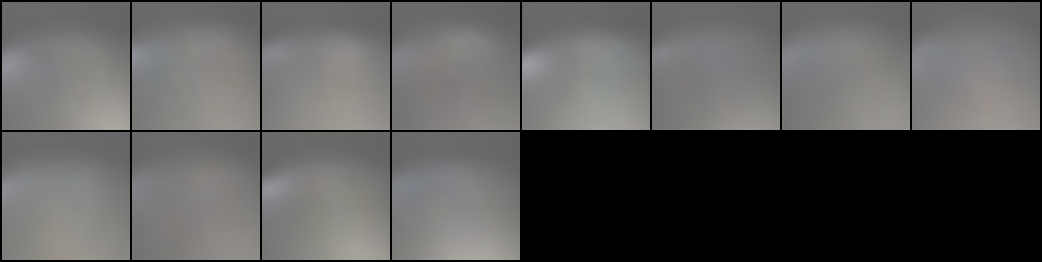

In [22]:
to_pil_grid(decoded_bg.detach().cpu())

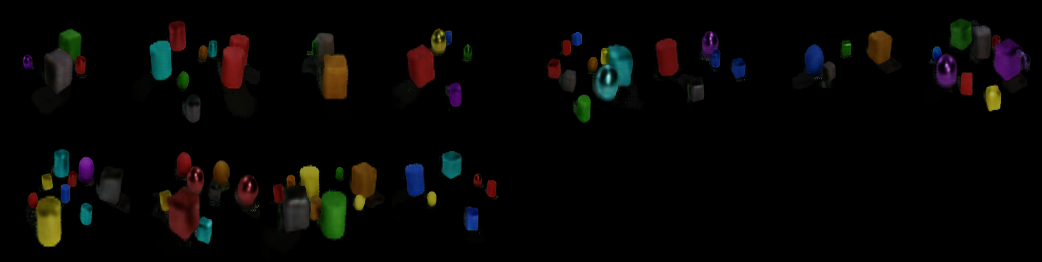

In [23]:
to_pil_grid(mu_fg.detach().cpu())

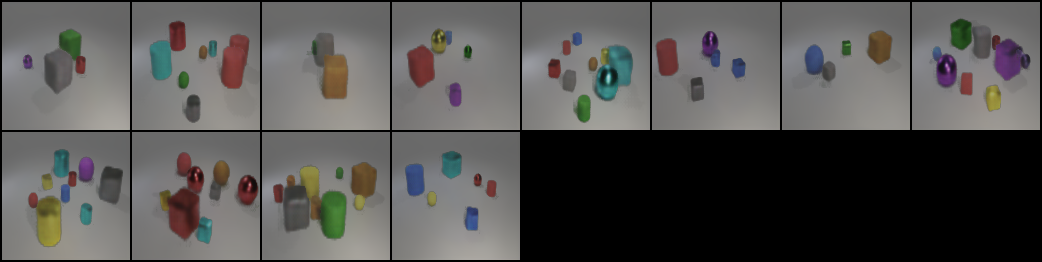

In [24]:
to_pil_grid(recon.detach().cpu())

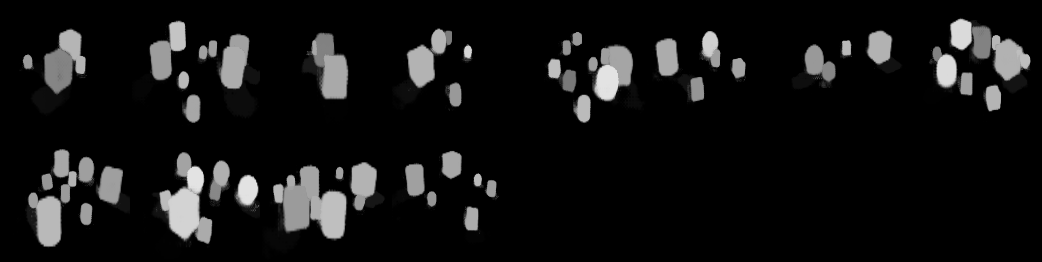

In [25]:
to_pil_grid(alpha.detach().cpu())

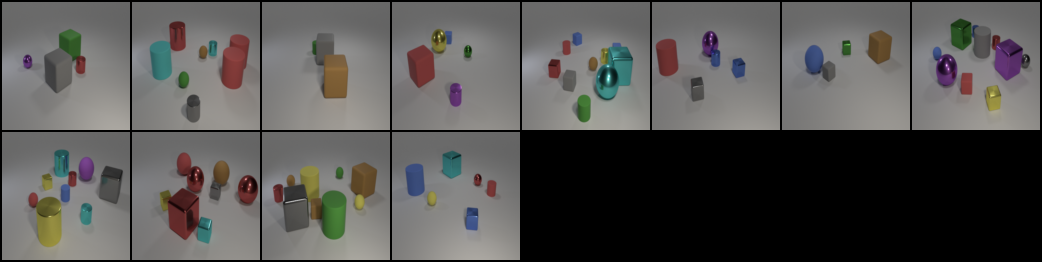

In [26]:
to_pil_grid(inp.cpu())

In [40]:
glimpses = rendered['glimpses']
y_glimpse = rendered['y_glimpse']
alpha_hat_glimpse = rendered['alpha_hat_glimpse']
y_glimpse.size()

torch.Size([12, 17, 3, 32, 32])

In [52]:
glimpses[0].size()

torch.Size([17, 3, 32, 32])

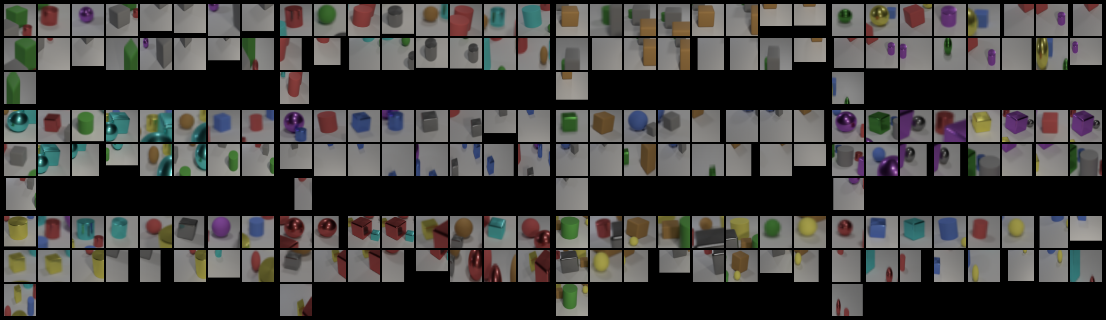

In [32]:
to_pil_grid(torch.stack([tv.utils.make_grid(g.detach().cpu()) for g in glimpses], 0), nrow=4)

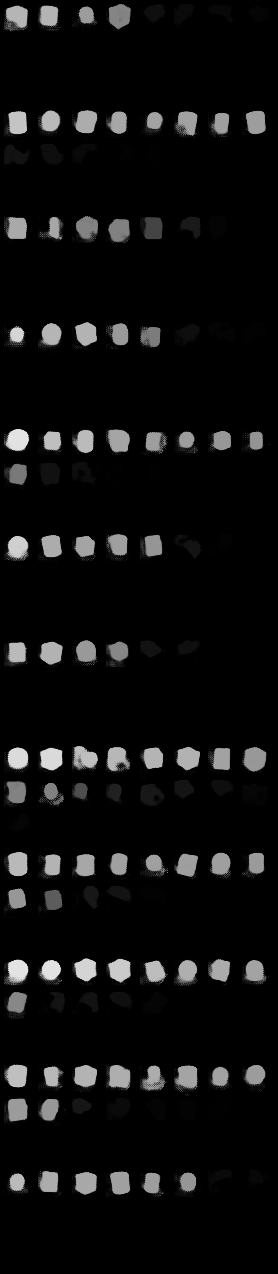

In [43]:
to_pil_grid(torch.stack([tv.utils.make_grid(a.detach().cpu()) for a in alpha_hat_glimpse], 0), nrow=1)

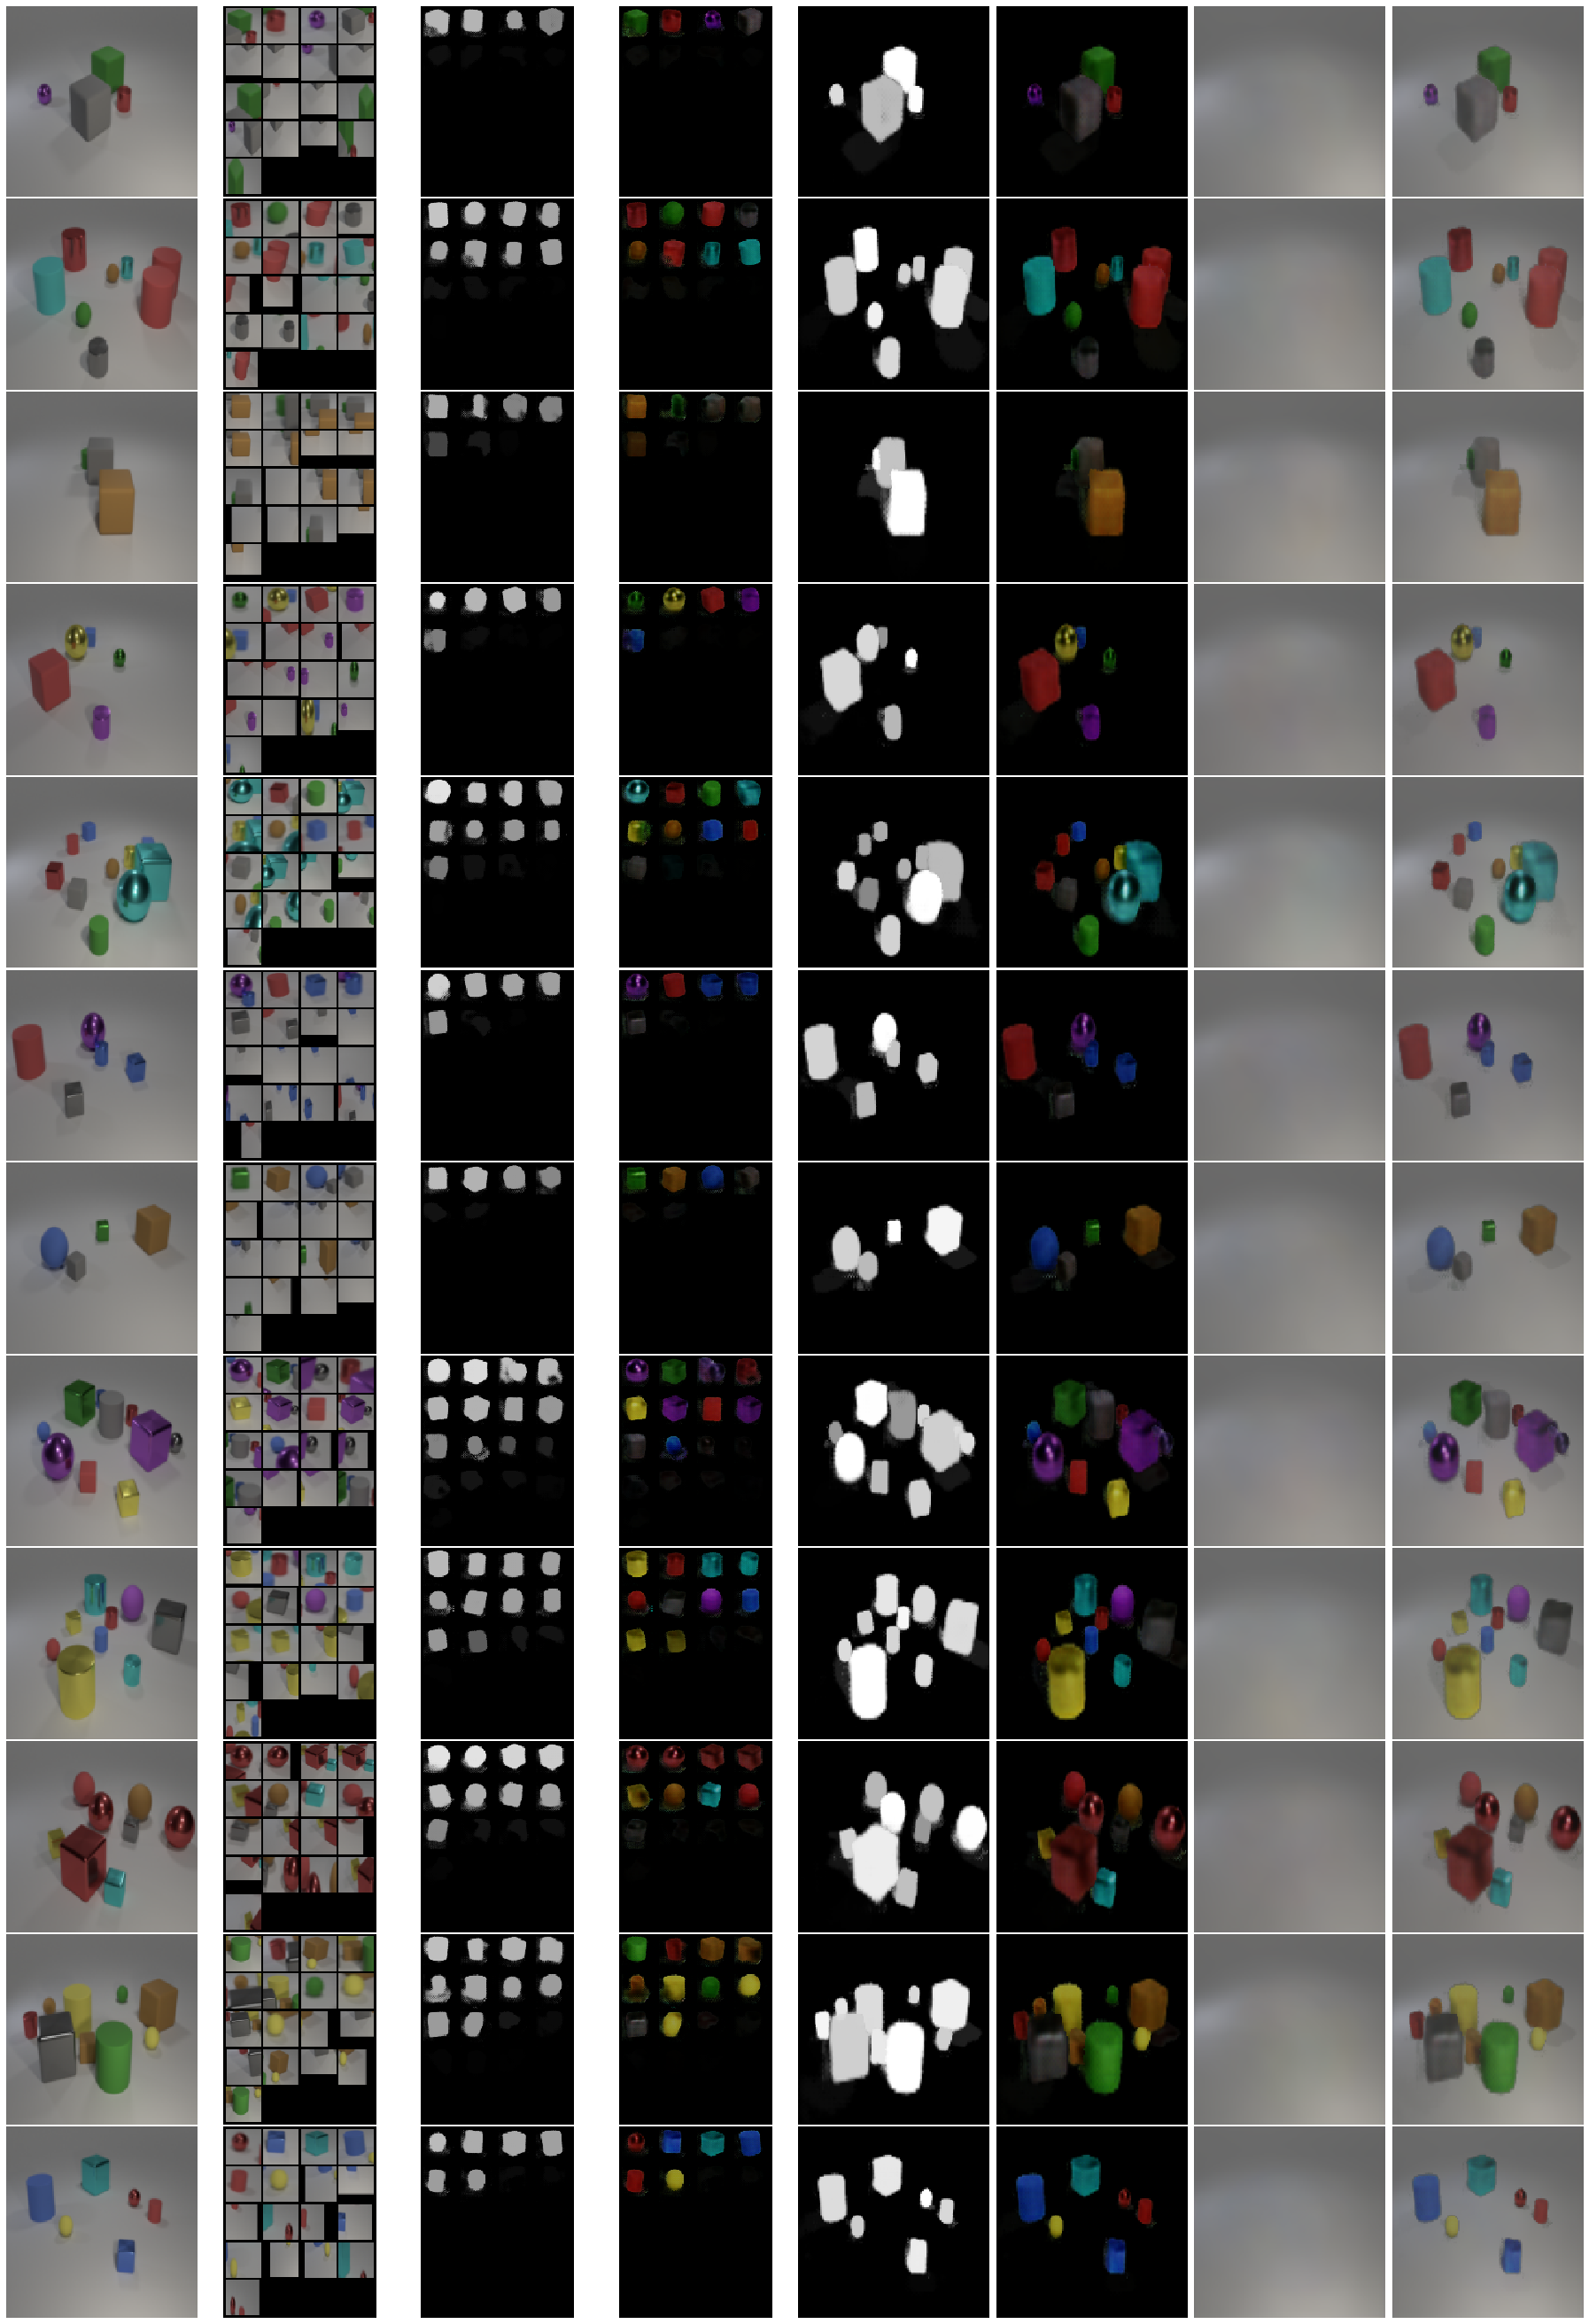

In [67]:
fig, axes = plt.subplots(nrows=bsz, ncols=8, figsize=(8 * 4, bsz * 4))
for i, img in enumerate(inp):
    inp_ax = axes[i][0]
    inp_ax.imshow(img.cpu().permute(1, 2, 0))
    inp_ax.axis('off')
    
    glimpse_ax = axes[i][1]
    glimpse_i = glimpses[i]
    glimpse_ax.imshow(to_pil_grid(glimpse_i.detach().cpu(), nrow=4))
    glimpse_ax.axis('off')
    
    alpha_hat_glimpse_ax = axes[i][2]
    alpha_hat_glimpse_i = alpha_hat_glimpse[i]
    alpha_hat_glimpse_ax.imshow(to_pil_grid(alpha_hat_glimpse_i.detach().cpu(), nrow=4))
    alpha_hat_glimpse_ax.axis('off')
    
    y_glimpse_ax = axes[i][3]
    y_glimpse_i = y_glimpse[i]
    y_glimpse_ax.imshow(to_pil_grid(y_glimpse_i.detach().cpu(), nrow=4))
    y_glimpse_ax.axis('off')
    
    y_glimpse_ax = axes[i][3]
    y_glimpse_i = y_glimpse[i]
    y_glimpse_ax.imshow(to_pil_grid(y_glimpse_i.detach().cpu(), nrow=4))
    y_glimpse_ax.axis('off')
    
    alpha_ax = axes[i][4]
    alpha_i = alpha[i]
    alpha_ax.imshow(alpha_i.detach().cpu().squeeze(0), cmap='gray')
    alpha_ax.axis('off')
    
    mu_fg_ax = axes[i][5]
    mu_fg_i = mu_fg[i]
    mu_fg_ax.imshow(mu_fg_i.detach().cpu().permute(1, 2, 0))
    mu_fg_ax.axis('off')
    
    bg_ax = axes[i][6]
    bg_i = decoded_bg[i]
    bg_ax.imshow(bg_i.detach().cpu().permute(1, 2, 0), )
    bg_ax.axis('off')
    
    recon_ax = axes[i][7]
    recon_i = recon[i]
    recon_ax.imshow(recon_i.detach().cpu().permute(1, 2, 0))
    recon_ax.axis('off')

plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.show()

In [41]:
torch.stack([tv.utils.make_grid(a.detach().cpu()) for a in alpha_hat_glimpse], 0).size()

torch.Size([12, 3, 104, 274])

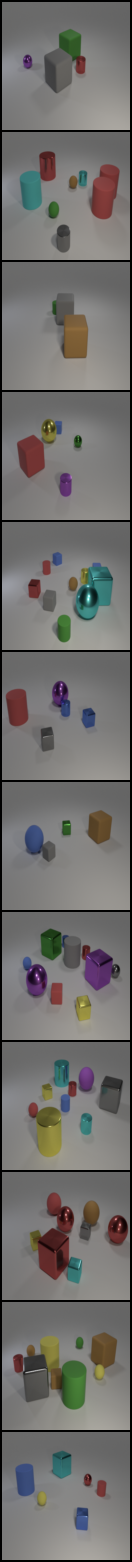

In [38]:
to_pil_grid(inp.cpu(), nrow=1)

In [29]:
glimpses.size()

torch.Size([12, 17, 3, 32, 32])

In [27]:
to_pil_grid(
    (glimpses * presence.flatten(1).unsqueeze(-1).unsqueeze(-1).unsqueeze(-1))[1].detach().cpu(),
    nrow=14,
)

NameError: name 'glimpses' is not defined

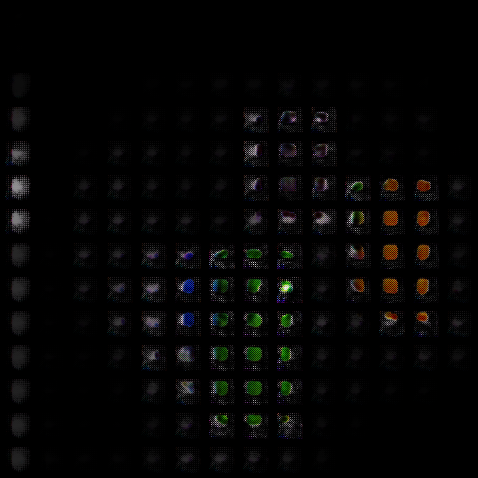

In [53]:
to_pil_grid(
    y_glimpse.flatten(1,2)[0].detach().cpu(),
    nrow=14,
)

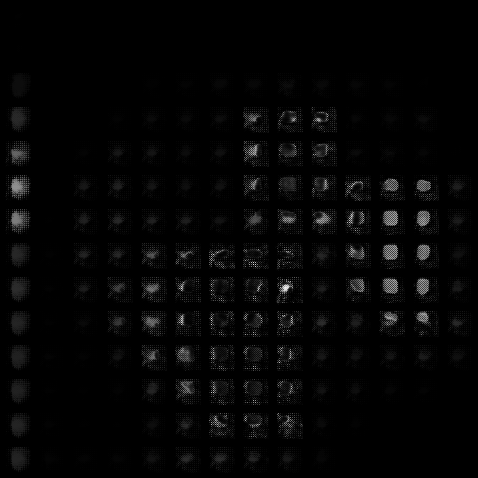

In [52]:
to_pil_grid(
    y_glimpse.flatten(1,2)[0, :, [0]].detach().cpu(),
    nrow=14,
)

In [84]:
presence.flatten(1).min(1)

torch.return_types.min(
values=tensor([0.11, 0.12, 0.07, 0.06, 0.07, 0.11, 0.10, 0.13, 0.05, 0.12, 0.09, 0.08, 0.09, 0.09, 0.11, 0.09], device='cuda:0', grad_fn=<MinBackward0>),
indices=tensor([58, 62, 62, 61, 61, 58, 63, 46, 62, 57, 62, 62, 57, 55, 62, 62], device='cuda:0'))